<a href="https://colab.research.google.com/github/1rafaelmayer/spiral-scans-reconstruction/blob/main/Spiral_Scan_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconstructing Sparsely Sampled Scanning Probe Microscopy Images with Gaussian Process

This tutorial will guide you through the process of reconstructing images from sparsely sampled near-field microscopy data using Gaussian Process.

The code used here is based on the work by Fu, Matthew, et al., titled "Accelerated Nano-Optical Imaging through Sparse Sampling," published in *Nano Letters* (2024). You can find the original paper [here](https://pubs.acs.org/doi/10.1021/acs.nanolett.3c03733).

If you plan to use this code, please remember to cite our work.

**Why does this matter?**

Near-field microscopy (s-SNOM) lets us capture extremely detailed images of a sample, down to just a few nanometers. It's particularly useful for identifying materials based on their chemical makeup. However, scanning the entire image pixel by pixel can be very time-consuming. Ideally, we want to measure only as many pixels as needed to get the information we want.

Instead of scanning an image line by line (raster scanning), the idea here is to scan only a few pixels and then use an algorithm to reconstruct the full image. There are several ways to do this, such as compressed sensing, but in this tutorial, we’ll focus on using Gaussian Process. We’ll scan the image using a spiral pattern, which covers most of the image content with a continuous motion.

In this tutorial, I’ll show you how to:

- Load the data
- Simulate a spiral scan from a real s-SNOM image
- Test the Gaussian Process for image reconstruction
- Choose appropriate Kernel for Gaussian Process

---

Importing python packages

In [ ]:
# For loading images
from PIL import Image

# For visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors

#For data process
import numpy as np
import scipy.stats as st
from scipy.ndimage.interpolation import rotate
import scipy.signal as sg

#For Gaussian Process
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, WhiteKernel

<ipython-input-1-dcd1ff624436>:10: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import rotate


Defining helper functions

In [ ]:
def normalize_function(data):
    mean=(data).mean()
    data-=mean
    std=(data).max()
    data/=std
    return data

def spiral(a,b,theta):
    x=(a+b*theta)*np.cos(theta)
    y=(a+b*theta)*np.sin(theta)
    return x,y

## Loading data

In [ ]:
#Please check where the folder is in your computer.
# rawdata=np.loadtxt('Scan_300-s4-bwd.txt')

In [ ]:
# If its stored in Google Drie, use this
from google.colab import drive
drive.mount("/content/gdrive")
rawdata=np.loadtxt('/content/gdrive/My Drive/Scan_300-s4-bwd.txt')

Mounted at /content/gdrive


This is a raster scanned nano-IR image on the graphene/RuCl3 heterostructure at 1450 cm-1. The charge transfer plasmon polariton manifests itself as the fringe patterns along the edge and the circular patterns around defects. This image is less then 1 um x 1um in size!

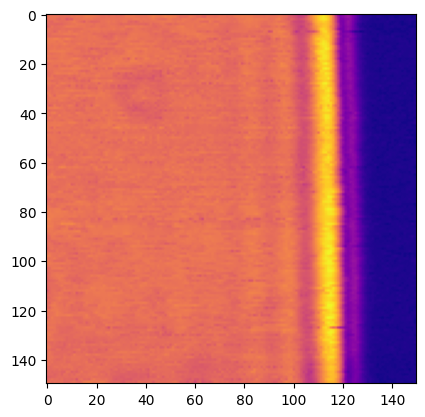

In [ ]:
plt.imshow(rawdata,cmap="plasma")

As we are scanning a spiral, our reconstructed image will not be a square, but a circle. Therefore, if we want to compare our reconstruction with the ground truth image, it is better to use circle window. Everything outside this circle will be zero.

In [ ]:
# This creates circle window
a=100
circle=np.ones([a,a])
for i in range(a):
    for j in range(a):
        if(np.sqrt((i-int(a/2))**2+(j-int(a/2))**2)>int(a/2)):
            circle[i,j]=0
data=normalize_function(np.array(Image.fromarray(rawdata).resize([a,a],resample=1))*circle)

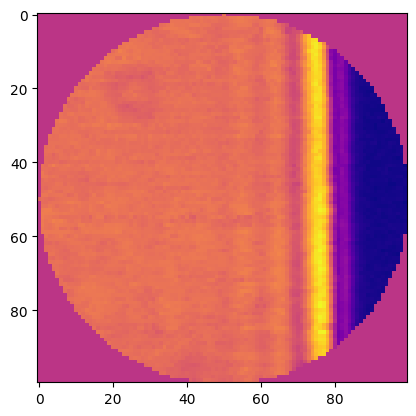

In [ ]:
data_compare=data*circle
plt.imshow(data_compare,cmap="plasma")

## Simulate the spiral scan and store it

In [ ]:
def spir(rawdata,data,density):
  "Here we create spiral scans of a specific density"
  a=100
  lim = 1
  res = data[0].size
  lin = np.linspace(-lim, lim, res)
  x1, x2 = np.meshgrid(lin, lin)
  xx = np.vstack((x1.flatten(), x2.flatten())).T
  y_analytic = rawdata.reshape(-1, res)
  N=density#Denisty of spiral
  theta1=np.linspace(0,N*np.pi,100000)
  b=(a/2-1)/(N*np.pi)
  x_spiral=np.array([0])
  y_spiral=np.array([0])
  data_spiral=np.array([rawdata[int(a/2),int(a/2)]])
  for i in theta1:
      if ((int(spiral(0,b,i)[0])!=x_spiral[-1]) or (int(spiral(0,b,i)[1])!=y_spiral[-1])):
          x_spiral=np.append(x_spiral,int(spiral(0,b,i)[0]))
          y_spiral=np.append(y_spiral,int(spiral(0,b,i)[1]))
          data_spiral=np.append(data_spiral,data[int(-spiral(0,b,i)[1])+int(a/2),int(spiral(0,b,i)[0])+int(a/2)])

  spiral_matrix=np.zeros(np.shape(rawdata))
  for i in range(np.shape(x_spiral)[0]):
      spiral_matrix[x_spiral+int(a/2),y_spiral+int(a/2)]=1

  spiral_data=rawdata*spiral_matrix
  x_spiral=x_spiral/int(a/2)
  y_spiral=y_spiral/int(a/2)
  return x_spiral,y_spiral,data_spiral

Here we plot a spiral scan of density 15.

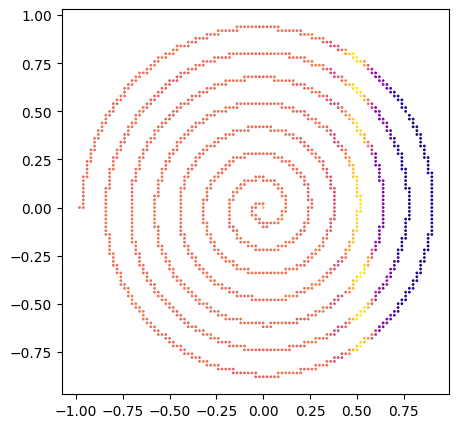

In [ ]:
x_spiral,y_spiral,data_spiral = spir(rawdata,data,15)
xx_spiral=np.vstack((x_spiral, y_spiral)).T
plt.figure(figsize=(5,5))
plt.scatter(x_spiral,y_spiral,s=1,c=data_spiral,cmap="plasma")
plt.axes().set_aspect('equal')
plt.axis("off")
plt.show()

## Gaussian Reconstruction
Let's test here a gaussian reconstruction of the spiral above. Here we use a RBF kernel with a predefined set of hyperparameters.

In [ ]:
kernel = RBF()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10,alpha=5e-3,random_state=42,normalize_y=True)
gp.fit(xx_spiral, data_spiral)
print("Learned kernel", gp.kernel_)

Learned kernel RBF(length_scale=0.0821)


In [ ]:
#Reshaping the data and predicting the results.
lim = 1
res = np.shape(data)[0]
lin = np.linspace(-lim, lim, res)
# x1.shape = (50, 50)
x1, x2 = np.meshgrid(lin, lin)
# xx.shape = (2500, 2)
xx = np.vstack((x1.flatten(), x2.flatten())).T
y_mean, y_cov = gp.predict(xx, return_cov=True)

Here we show the predicted and the error images.

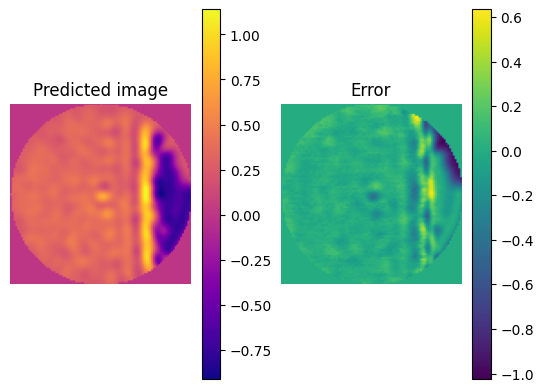

In [ ]:
mean = np.flip(y_mean.reshape(-1, res),axis=0)*circle
error=data_compare-np.flip(y_mean.reshape(-1, res),axis=0)*circle

plt.figure(dpi=100)
plt.subplot(121)
plt.title('Predicted image')
plt.imshow(mean,cmap="plasma")
plt.axis("off")
plt.colorbar()
plt.subplot(122)
plt.title('Error')
plt.imshow(error,cmap="viridis")
plt.axis("off")
plt.colorbar()
plt.show()

## Choosing an appropriate Kernel
There are many different Kernels in Gaussian Process. Some work better then others, and this depends on each case. Let's find the absolute error for each Kernel first using a spiral density of 8.

In [ ]:
# Define the data and the kernel parameters
x_spiral, y_spiral, data_spiral = spir(rawdata, data, 8)
xx_spiral = np.vstack((x_spiral, y_spiral)).T
alpha = 0.0
random_state = 42
n_restarts_optimizer = 10
normalize_y = True
lim = 1
res = np.shape(data)[0]
lin = np.linspace(-lim, lim, res)
x1, x2 = np.meshgrid(lin, lin)
xx = np.vstack((x1.flatten(), x2.flatten())).T

# Define the kernels to test
kernels = [RBF(), Matern(), RationalQuadratic()]

# Train a Gaussian process for each kernel and evaluate its performance
param = []
error_k = []
mean_im = []
error_im = []
for kernel in kernels:
    gp = GaussianProcessRegressor(kernel=1*kernel + WhiteKernel(noise_level=alpha),
                                  n_restarts_optimizer=10,
                                  alpha=alpha,
                                  random_state=random_state,
                                  normalize_y=normalize_y)
    gp.fit(xx_spiral, data_spiral)
    print("Learned kernel:", gp.kernel_)
    param.append(gp.kernel_)
    y_mean, y_cov = gp.predict(xx, return_cov=True)
    mean = np.flip(y_mean.reshape(-1, res), axis=0) * circle
    mean_im.append(mean)
    error = data_compare - np.flip(y_mean.reshape(-1, res), axis=0) * circle
    error_im.append(error)
    saved_error = np.sum(abs(error))
    print("Error:", saved_error)
    error_k.append(saved_error)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:284: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Learned kernel: 0.798**2 * RBF(length_scale=0.0784) + WhiteKernel(noise_level=0.00422)
Error: 863.689650306587


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:284: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Learned kernel: 1.01**2 * Matern(length_scale=0.198, nu=1.5) + WhiteKernel(noise_level=0.00236)
Error: 582.4184457739088


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:284: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Learned kernel: 1.17**2 * RationalQuadratic(alpha=0.257, length_scale=0.145) + WhiteKernel(noise_level=0.00329)
Error: 568.6600604780286


We see that for this spiral density (and using this predefined set of hyperparameters) the RationalQuadratic kernel have the smallest errors.

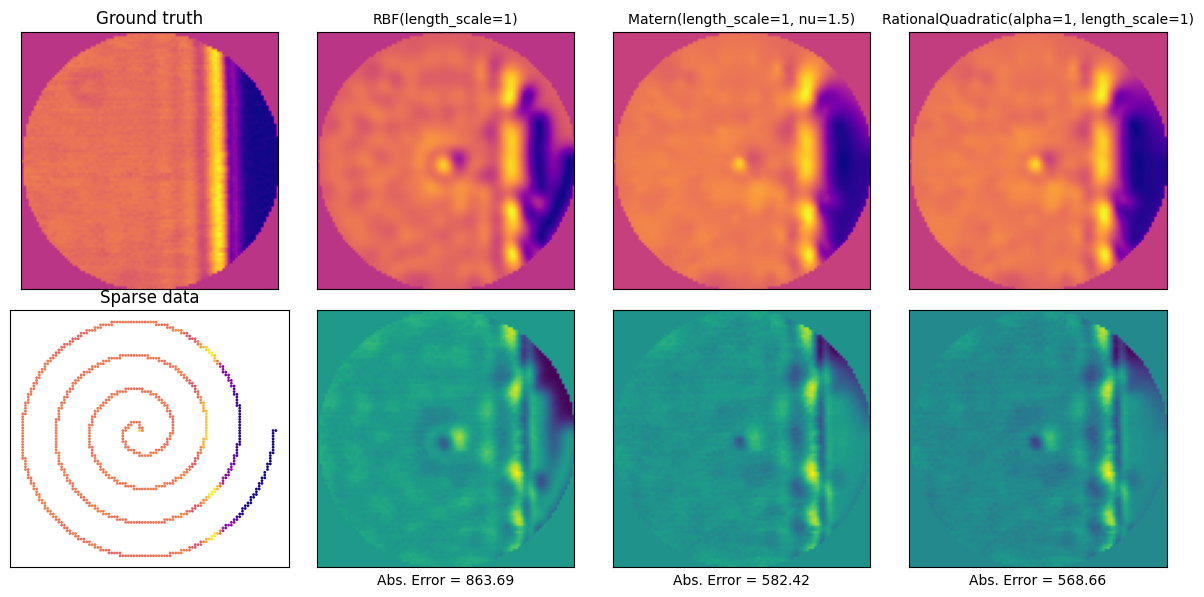

In [ ]:
fig, axs = plt.subplots(2, len(kernels)+1, figsize=(12, 6))

# plot ground truth and sparse data
axs[0, 0].imshow(data_compare,cmap="plasma")
axs[1, 0].scatter(x_spiral,y_spiral,s=1,c=data_spiral,cmap="plasma")
axs[1, 0].axes.set_aspect('equal')
axs[0, 0].set_title('Ground truth')
axs[1, 0].set_title('Sparse data')

# plot mean images and error images
for i in range(len(kernels)):
    axs[0, i+1].imshow(mean_im[i],cmap="plasma")
    axs[1, i+1].imshow(error_im[i],cmap="viridis")
    axs[0, i+1].set_title(str(kernels[i]),size=10)
    axs[1, i+1].set_xlabel('Abs. Error = '+str(round(error_k[i],2)))

# remove tick labels and adjust layout
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

# show plot
plt.show()



We can check if this depends on the spiral density for example. (This code below takes a long time to calculate. For simplicity let's calculate only for spiral densities of 2,5, and 10, and RBF and Rational Quadratic kernels)

In [ ]:
#kernels = [RBF(), Matern(), RationalQuadratic()]
kernels = [RBF(), RationalQuadratic()]

N = np.array([2,5,10])

param_N = []
error_N = []
mean_im_N = []
error_im_N = []

for i in range(len(N)):
  print(N[i])

  # Define the data and the kernel parameters
  x_spiral, y_spiral, data_spiral = spir(rawdata, data, N[i])
  xx_spiral = np.vstack((x_spiral, y_spiral)).T
  alpha = 0.0
  random_state = 42
  n_restarts_optimizer = 10
  normalize_y = True
  lim = 1
  res = np.shape(data)[0]
  lin = np.linspace(-lim, lim, res)
  x1, x2 = np.meshgrid(lin, lin)
  xx = np.vstack((x1.flatten(), x2.flatten())).T

  # Train a Gaussian process for each kernel and evaluate its performance
  param_k = []
  error_k = []
  mean_im_k = []
  error_im_k = []
  for kernel in kernels:
    print('running kernel...')
    gp = GaussianProcessRegressor(kernel=1*kernel + WhiteKernel(noise_level=alpha),
                                  n_restarts_optimizer=10,
                                  alpha=alpha,
                                  random_state=random_state,
                                  normalize_y=normalize_y)
    gp.fit(xx_spiral, data_spiral)
    print("Learned kernel:", gp.kernel_)
    param_k.append(gp.kernel_)
    y_mean, y_cov = gp.predict(xx, return_cov=True)
    mean = np.flip(y_mean.reshape(-1, res), axis=0) * circle
    mean_im_k.append(mean)
    error = data_compare - np.flip(y_mean.reshape(-1, res), axis=0) * circle
    error_im_k.append(error)
    saved_error = np.sum(abs(error))
    print("Error:", saved_error)
    error_k.append(saved_error)

  param_N.append(param_k)
  error_N.append(error_k)
  mean_im_N.append(mean_im_k)
  error_im_N.append(error_im_k)

error_N_KER = np.array(error_N)

2
running kernel...


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:284: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Learned kernel: 0.747**2 * RBF(length_scale=0.0704) + WhiteKernel(noise_level=0.00206)
Error: 1985.220824654904
running kernel...


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:284: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Learned kernel: 1.27**2 * RationalQuadratic(alpha=0.106, length_scale=0.176) + WhiteKernel(noise_level=0.0014)
Error: 1320.2876746694676
5
running kernel...


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:284: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Learned kernel: 0.839**2 * RBF(length_scale=0.081) + WhiteKernel(noise_level=0.00452)
Error: 1221.0891401616211
running kernel...


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:284: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Learned kernel: 1.21**2 * RationalQuadratic(alpha=0.195, length_scale=0.149) + WhiteKernel(noise_level=0.00344)
Error: 833.7624786481016
10
running kernel...


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:284: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Learned kernel: 0.82**2 * RBF(length_scale=0.0772) + WhiteKernel(noise_level=0.00433)
Error: 675.4146368029645
running kernel...


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:284: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Learned kernel: 1.17**2 * RationalQuadratic(alpha=0.312, length_scale=0.139) + WhiteKernel(noise_level=0.00378)
Error: 460.5816946249206


As you can see, there is a spiral density number where the error dont decrease anymore. We also see that the RationalQuadratic kernel is the most appropriate for our case.

(0.0, 3000.0)

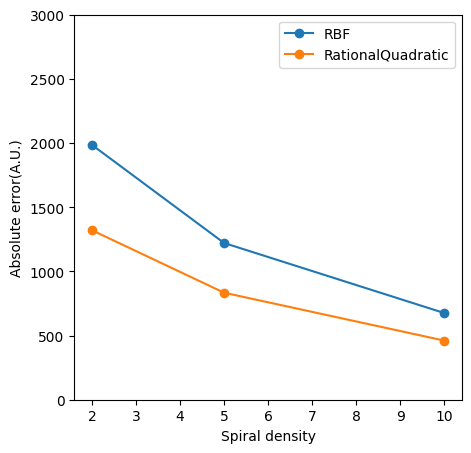

In [ ]:
plt.figure(dpi=100,figsize=(5,5))
plt.plot(N,error_N_KER[:,0],"o-",label='RBF')
plt.plot(N,error_N_KER[:,1],"o-",label='RationalQuadratic')
plt.xlabel("Spiral density")
plt.ylabel("Absolute error(A.U.)")
plt.legend()
plt.ylim(0,3000)

## Conclusion

We have walked through the know-how of Gaussian Process. In truth, there is much more to cover. We haven't talked about hyperparameter tuning, and more sophisticated things, such as active learning. But I hope I have inspired you all to keep learning this great tool!